#### redis Redis常用数据类型对应的数据结构

数据类型：字符串、列表、字典、集合、有序集合。

#### 列表（list）

列表这种数据类型支持存储一组数据。这种数据类型对应两种实现方法，一种是压缩列表（ziplist），另一种是双向循环链表。

##### 压缩列表 （ziplist）
当列表中存储的数据量比较小的时候，列表就可以采用压缩列表的方式实现。

具体需要同时满足下面两个条件：
* 列表中保存的单个数据（有可能是字符串类型的）小于 64 字节；
* 列表中数据个数少于 512 个。

压缩列表，不是基础数据结构，而是 Redis 自己设计的一种数据存储结构。类似数组，通过一片连续的内存空间，来存储数据。不过，它跟数组不同的一点是，它允许存储的数据大小不同。具体的存储结构也非常简单
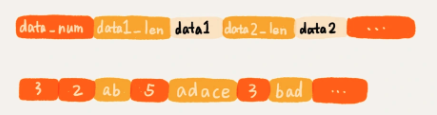

压缩：
* 之所以说这种存储结构节省内存，是相较于数组的存储思路而言的
* 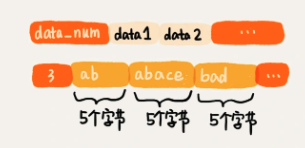
* 压缩列表这种存储结构，一方面比较节省内存，另一方面可以支持不同类型数据的存储。而且，因为数据存储在一片连续的内存空间，通过键来获取值为列表类型的数据，读取的效率也非常高。

##### 双向

Redis 的这种双向链表的实现方式，非常值得借鉴。它额外定义一个 list 结构体，来组织链表的首、尾指针，还有长度等信息。这样，在使用的时候就会非常方便。

~~~

// 以下是C语言代码，因为Redis是用C语言实现的。
typedef struct listnode {
  struct listNode *prev;
  struct listNode *next;
  void *value;
} listNode;


typedef struct list {
  listNode *head;
  listNode *tail;
  unsigned long len;
  // ....省略其他定义
} list;

~~~

#### 字典（hash）

字典类型用来存储一组数据对。每个数据对又包含键值两部分。字典类型也有两种实现方式。一种是我们刚刚讲到的压缩列表，另一种是散列表。

##### 压缩列表

只有当存储的数据量比较小的情况下，Redis 才使用压缩列表来实现字典类型。
具体需要满足两个条件：
* 字典中保存的键和值的大小都要小于 64 字节；
* 字典中键值对的个数要小于 512 个。

##### 散列表
Redis 使用 MurmurHash2 这种运行速度快、随机性好的哈希算法作为哈希函数。对于哈希冲突问题，Redis 使用链表法来解决。除此之外，Redis 还支持散列表的动态扩容、缩容。

当数据动态增加之后，散列表的装载因子会不停地变大。为了避免散列表性能的下降，当装载因子大于 1 的时候，Redis 会触发扩容，将散列表扩大为原来大小的 2 倍左右

当数据动态减少之后，为了节省内存，当装载因子小于 0.1 的时候，Redis 就会触发缩容，缩小为字典中数据个数的大约 2 倍大小

扩容缩容要做大量的数据搬移和哈希值的重新计算，所以比较耗时。针对这个问题，Redis 使用我们在散列表（中）讲的渐进式扩容缩容策略，将数据的搬移分批进行，避免了大量数据一次性搬移导致的服务停顿。

#### 集合（set）

集合这种数据类型用来存储一组不重复的数据。这种数据类型也有两种实现方法，一种是基于有序数组，另一种是基于散列表。

当要存储的数据，同时满足下面这样两个条件的时候，Redis 就采用有序数组，来实现集合这种数据类型。
* 存储的数据都是整数；
* 存储的数据元素个数不超过 512 个。
当不能同时满足这两个条件的时候，Redis 就使用散列表来存储集合中的数据。

#### 有序集合（sortedset）

它用来存储一组数据，并且每个数据会附带一个得分。通过得分的大小，我们将数据组织成跳表这样的数据结构，以支持快速地按照得分值、得分区间获取数据。

实际上，跟 Redis 的其他数据类型一样，有序集合也并不仅仅只有跳表这一种实现方式。
当数据量比较小的时候，Redis 会用压缩列表来实现有序集合。
具体点说就是，使用压缩列表来实现有序集合的前提，有这样两个：
* 所有数据的大小都要小于 64 字节；
* 元素个数要小于 128 个。
